<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Продвинутый поток. Весна 2021</b></h3>

Это домашнее задание будет посвящено полноценному решению задачи машинного обучения.

Есть две части этого домашнего задания: 
* Сделать полноценный отчет о вашей работе: как вы обработали данные, какие модели попробовали и какие результаты получились (максимум 10 баллов). За каждую выполненную часть будет начислено определенное количество баллов.
* Лучшее решение отправить в соревнование на [kaggle](https://www.kaggle.com/c/advanced-dls-spring-2021/) (максимум 5 баллов). За прохождение определенного порогов будут начисляться баллы.


**Обе части будут проверяться в формате peer-review. Т.е. вашу посылку на степик будут проверять несколько других студентов и аггрегация их оценок будет выставлена. В то же время вам тоже нужно будет проверить несколько других учеников.**

**Пожалуйста, делайте свою работу чистой и понятной, чтобы облегчить проверку. Если у вас будут проблемы с решением или хочется совета, то пишите в наш чат в телеграме или в лс @runfme. Если вы захотите проаппелировать оценку, то пипшите в лс @runfme.**

**Во всех пунктах указания это минимальный набор вещей, которые стоит сделать. Если вы можете сделать какой-то шаг лучше или добавить что-то свое - дерзайте!**

# Как проверять?

Ставьте полный балл, если выполнены все рекомендации или сделано что-то более интересное и сложное. За каждый отсустствующий пункт из рекомендация снижайте 1 балл.

# Метрика

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она раотает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


# Первая часть. Исследование

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

## Загрузка данных (2 балла)

1) Посмотрите на случайные строчки. 

2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите табличку с количеством nan в каждой колонке.

In [2]:
data = pd.read_csv('./train.csv')

In [3]:
num_features = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

cat_features = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_features + cat_features
target_col = 'Churn'

In [4]:
print((data[feature_cols] == ' ').sum())

ClientPeriod                0
MonthlySpending             0
TotalSpent                  9
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
dtype: int64


In [5]:
def preprocessing(data):
    data['TotalSpent'] = pd.to_numeric(data['TotalSpent'], errors='coerce') # Тип столбца TotalSpent = str,так как там есть пустые строки, поэтому кастую его к числовому
    data = data.fillna(data['TotalSpent'].mean()) # Замена nan-значений средним значением в столбце TotalSpent
    print(data.shape == data.dropna().shape) # Проверка отстуствия nan-значений

    return data


In [6]:
data = preprocessing(data)

random_str = np.random.randint(0,data.shape[0]) # Вывод рандомной строки
print(data.iloc[random_str,:])

# Вывод количества всех НЕ nan значений в столбце
for col in feature_cols:
  print(data[col].isna().value_counts())
print(data[target_col].isna().value_counts())

True
ClientPeriod                              19
MonthlySpending                         88.2
TotalSpent                            1775.8
Sex                                     Male
IsSeniorCitizen                            1
HasPartner                                No
HasChild                                  No
HasPhoneService                          Yes
HasMultiplePhoneNumbers                  Yes
HasInternetService               Fiber optic
HasOnlineSecurityService                  No
HasOnlineBackup                          Yes
HasDeviceProtection                       No
HasTechSupportAccess                      No
HasOnlineTV                              Yes
HasMovieSubscription                      No
HasContractPhone              Month-to-month
IsBillingPaperless                       Yes
PaymentMethod               Electronic check
Churn                                      1
Name: 922, dtype: object
False    5282
Name: ClientPeriod, dtype: int64
False    5282
Name: Mon

## Анализ данных (3 балла)

1) Для численных призанков постройте гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* (хорошо, елси вы сможете это сделать на одном гарфике с помощью *plt.subplots(...)*). 

2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

3) (Если будет желание) Поиграйте с разными библиотеками для визуализации - *sns*, *pandas_visual_analysis*, etc.

Второй пункт очень важен, потому что существуют задачи классификации с несбалансированными классами. Например, это может значить, что в датасете намного больше примеров 0 класса. В таких случаях нужно 1) не использовать accuracy как метрику 2) использовать методы борьбы с imbalanced dataset (обычно если датасет сильно несбалансирован, т.е. класса 1 в 20 раз меньше класса 0).

0    3898
1    1384
Name: Churn, dtype: int64


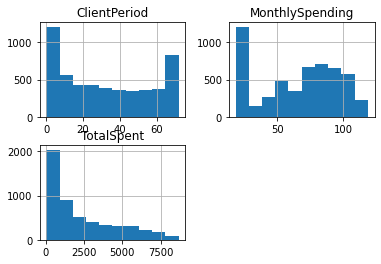

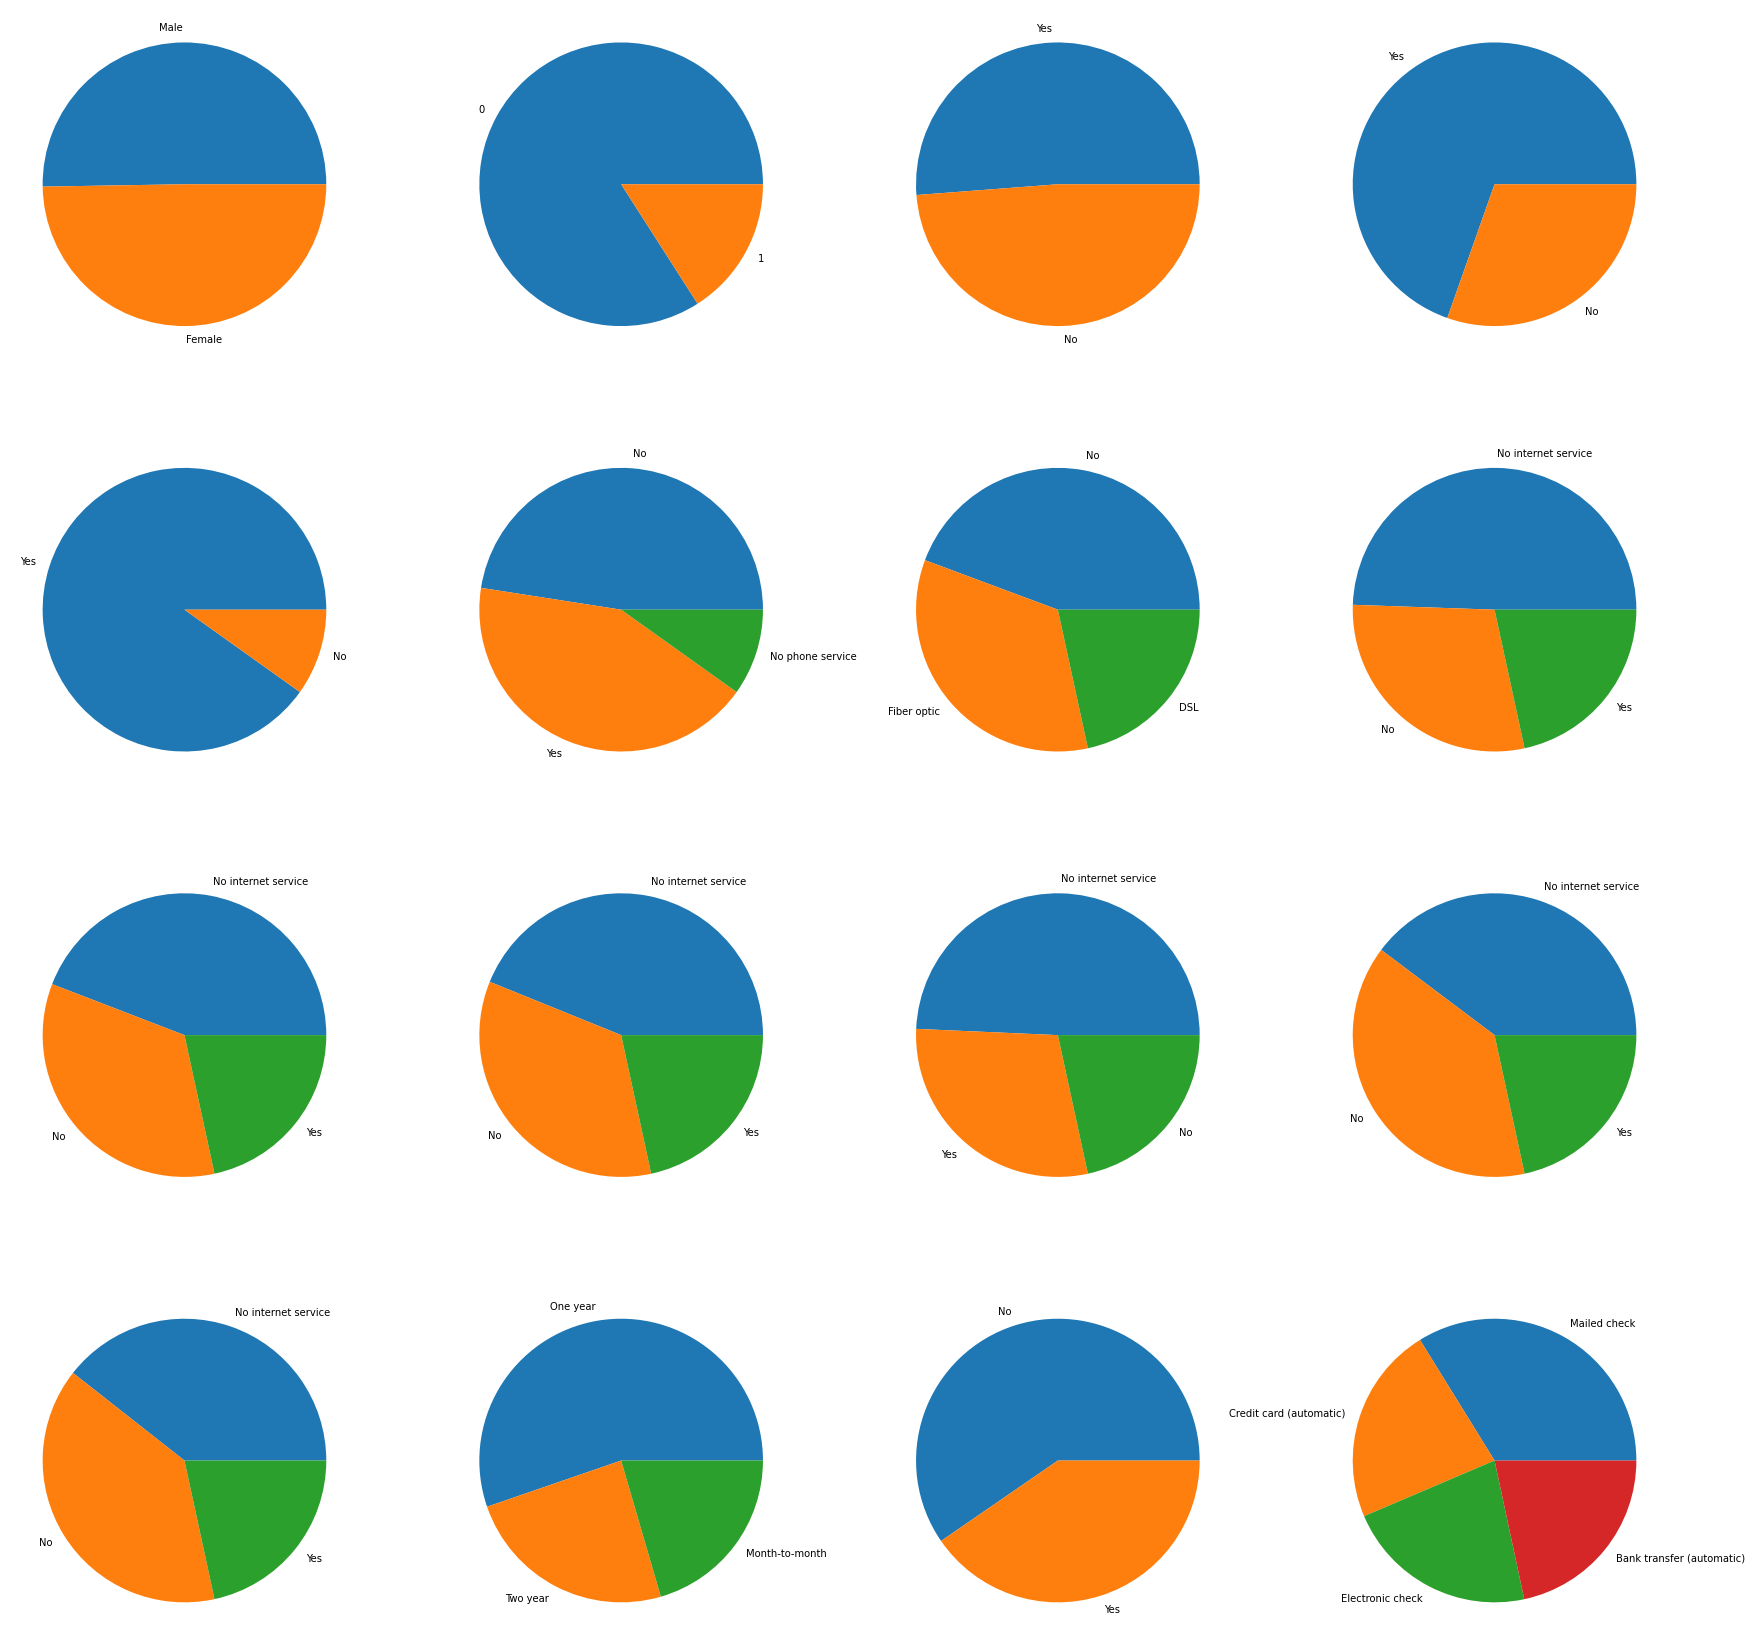

0    0.737978
1    0.262022
Name: Churn, dtype: float64


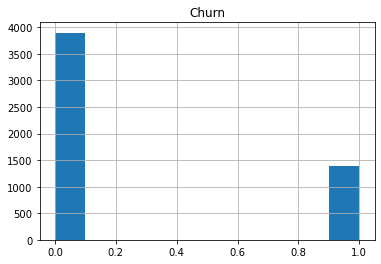

In [7]:
data.hist(column=num_features)

fig, ax = plt.subplots(4,4, figsize=(30,30))

for i in range(4):
  for j in range(4):
        ax[i,j].pie(data[cat_features[4*i + j]].value_counts(), labels = data[cat_features[4*i + j]].unique())

print(data[target_col].value_counts())
plt.show()

data.hist(column=target_col)
print(data[target_col].value_counts()/len(data)) # Классы несбалансированны

(Дополнительно) Если вы нашли какие-то ошибки в данных или выбросы, то можете их убрать. Тут можно поэксперементировать с обработкой данных как угодно, но не за баллы.

## Применение линейных моделей (3 балла)

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а. 

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC. 

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C). 


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.)

In [8]:
X = data[feature_cols]
y = data[target_col]

In [10]:
col_transformer = ColumnTransformer(transformers=[('num_feature', StandardScaler(), num_features),
                                    ('oh_cat_feature', OneHotEncoder(), cat_features)])
pipeline = make_pipeline(col_transformer, 
                    LogisticRegression())
params = {
    'logisticregression__max_iter': [100],
    'logisticregression__C': [100], 
    'logisticregression__solver': ['saga']
}

lin_model = GridSearchCV(estimator = pipeline,
                        param_grid = params,
                        cv=5,
                        scoring='roc_auc',
                        n_jobs=-1,
                        verbose=10)

lin_model.fit(X, y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num_feature',
                                                                         StandardScaler(),
                                                                         ['ClientPeriod',
                                                                          'MonthlySpending',
                                                                          'TotalSpent']),
                                                                        ('oh_cat_feature',
                                                                         OneHotEncoder(),
                                                                         ['Sex',
                                                                          'IsSeniorCitizen',
                                                                          'HasPartner',
                         

In [11]:
y_predict = lin_model.predict_proba(X)[:, 1]

res = roc_auc_score(y, y_predict)
print(res)
print(lin_model.best_params_)

0.8488741632732957
{'logisticregression__C': 100, 'logisticregression__max_iter': 100, 'logisticregression__solver': 'saga'}


Выпишите какое лучшее качество и с какими параметрами вам удалось получить

## Применение градиентного бустинга (2 балла)

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с дефолтными параметрами даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию. 

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

In [36]:
!pip install catboost

     |████████████████████████████████| 76.6 MB 1.4 MB/s 


In [12]:
import catboost
from catboost.core import CatBoostClassifier

In [13]:
boosting_model = CatBoostClassifier(cat_features=cat_features)

# params = {'learning_rate' : [0.01, 0.02, 0.03, 0.04],
#           'n_estimators' : [50, 100, 150, 200, 250, 300, 350, 400]
#           }

params = {'learning_rate' : [0.04],
          'n_estimators' : [400]
          }

CV_boosting_model = GridSearchCV(estimator=boosting_model,
                                 param_grid=params,
                                 cv=5,
                                 scoring='roc_auc',
                                 n_jobs=-1
                                 )

CV_boosting_model.fit(X, y)



0:	learn: 0.6671494	total: 87.6ms	remaining: 34.9s
1:	learn: 0.6418686	total: 113ms	remaining: 22.5s
2:	learn: 0.6209461	total: 138ms	remaining: 18.2s
3:	learn: 0.6010792	total: 161ms	remaining: 16s
4:	learn: 0.5852815	total: 183ms	remaining: 14.5s
5:	learn: 0.5692784	total: 210ms	remaining: 13.8s
6:	learn: 0.5554412	total: 233ms	remaining: 13.1s
7:	learn: 0.5435135	total: 253ms	remaining: 12.4s
8:	learn: 0.5317826	total: 279ms	remaining: 12.1s
9:	learn: 0.5213595	total: 308ms	remaining: 12s
10:	learn: 0.5113411	total: 330ms	remaining: 11.7s
11:	learn: 0.5041517	total: 348ms	remaining: 11.2s
12:	learn: 0.4969307	total: 370ms	remaining: 11s
13:	learn: 0.4900497	total: 390ms	remaining: 10.8s
14:	learn: 0.4840484	total: 413ms	remaining: 10.6s
15:	learn: 0.4789160	total: 433ms	remaining: 10.4s
16:	learn: 0.4734193	total: 455ms	remaining: 10.2s
17:	learn: 0.4682439	total: 479ms	remaining: 10.2s
18:	learn: 0.4642582	total: 496ms	remaining: 9.94s
19:	learn: 0.4600218	total: 521ms	remaining: 9

169:	learn: 0.3804379	total: 3.58s	remaining: 4.85s
170:	learn: 0.3803759	total: 3.6s	remaining: 4.83s
171:	learn: 0.3802648	total: 3.63s	remaining: 4.81s
172:	learn: 0.3802648	total: 3.63s	remaining: 4.76s
173:	learn: 0.3800848	total: 3.65s	remaining: 4.74s
174:	learn: 0.3799023	total: 3.67s	remaining: 4.72s
175:	learn: 0.3797954	total: 3.69s	remaining: 4.7s
176:	learn: 0.3797708	total: 3.71s	remaining: 4.67s
177:	learn: 0.3796510	total: 3.73s	remaining: 4.65s
178:	learn: 0.3795044	total: 3.75s	remaining: 4.63s
179:	learn: 0.3794569	total: 3.77s	remaining: 4.61s
180:	learn: 0.3794568	total: 3.78s	remaining: 4.57s
181:	learn: 0.3793862	total: 3.8s	remaining: 4.55s
182:	learn: 0.3791924	total: 3.82s	remaining: 4.53s
183:	learn: 0.3789592	total: 3.84s	remaining: 4.51s
184:	learn: 0.3788006	total: 3.87s	remaining: 4.49s
185:	learn: 0.3786184	total: 3.89s	remaining: 4.47s
186:	learn: 0.3784590	total: 3.91s	remaining: 4.45s
187:	learn: 0.3784584	total: 3.92s	remaining: 4.42s
188:	learn: 0.3

334:	learn: 0.3531939	total: 7.45s	remaining: 1.45s
335:	learn: 0.3530251	total: 7.47s	remaining: 1.42s
336:	learn: 0.3529195	total: 7.5s	remaining: 1.4s
337:	learn: 0.3526870	total: 7.52s	remaining: 1.38s
338:	learn: 0.3523990	total: 7.54s	remaining: 1.36s
339:	learn: 0.3522105	total: 7.57s	remaining: 1.33s
340:	learn: 0.3520845	total: 7.59s	remaining: 1.31s
341:	learn: 0.3518788	total: 7.62s	remaining: 1.29s
342:	learn: 0.3517630	total: 7.64s	remaining: 1.27s
343:	learn: 0.3516038	total: 7.67s	remaining: 1.25s
344:	learn: 0.3514645	total: 7.69s	remaining: 1.23s
345:	learn: 0.3512720	total: 7.72s	remaining: 1.2s
346:	learn: 0.3511371	total: 7.74s	remaining: 1.18s
347:	learn: 0.3510402	total: 7.77s	remaining: 1.16s
348:	learn: 0.3508168	total: 7.79s	remaining: 1.14s
349:	learn: 0.3506181	total: 7.82s	remaining: 1.12s
350:	learn: 0.3502512	total: 7.84s	remaining: 1.09s
351:	learn: 0.3501613	total: 7.86s	remaining: 1.07s
352:	learn: 0.3499212	total: 7.89s	remaining: 1.05s
353:	learn: 0.3

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x000000000D1C7160>,
             n_jobs=-1,
             param_grid={'learning_rate': [0.04], 'n_estimators': [400]},
             scoring='roc_auc')

In [21]:
y_predicted = CV_boosting_model.predict_proba(X)[:, 1]

print(roc_auc_score(y, y_predicted))
print(boosting_model.tree_count_)

0.88552516556586
None


Выпишите какое лучшее качество и с какими параметрами вам удалось получить

# Предсказания

In [22]:
best_model = CV_boosting_model

In [23]:
X_test = pd.read_csv('./test.csv')
X_test = preprocessing(X_test)
submission = pd.read_csv('./submission.csv')

submission['Churn'] = best_model.predict_proba(X_test)[:, 1]
submission.to_csv('./my_submission.csv', index=False)
submission.head()

True


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Id,Churn
0,0,0,0,0,0.041096
1,1,1,1,1,0.740627
2,2,2,2,2,0.662797
3,3,3,3,3,0.012374
4,4,4,4,4,0.003663


# Kaggle (5 баллов)

Как выставить баллы:

1) 1 >= roc auc > 0.84 это 5 баллов

2) 0.84 >= roc auc > 0.7 это 3 балла

3) 0.7 >= roc auc > 0.6 это 1 балл

4) 0.6 >= roc auc это 0 баллов


Для выполнения задания необходимо выполнить следующие шаги.
* Зарегистрироваться на платформе [kaggle.com](kaggle.com). Процесс выставления оценок будет проходить при подведении итогового рейтинга. Пожалуйста, укажите во вкладке Team -> Team name свои имя и фамилию в формате Имя_Фамилия (важно, чтобы имя и фамилия совпадали с данными на Stepik).
* Обучить модель, получить файл с ответами в формате .csv и сдать его в конкурс. Пробуйте и экспериментируйте. Обратите внимание, что вы можете выполнять до 20 попыток сдачи на kaggle в день.
* После окончания соревнования отправить в итоговый ноутбук с решением на степик. 
* После дедлайна проверьте посылки других участников по критериям. Для этого надо зайти на степик, скачать их ноутбук и проверить скор в соревновании.